# Building a causal predictor for the reproduction number

Predicting the reproduction number in the future, using only training data available in the present.

## Loading packages and data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import os
import warnings
import statsmodels.api as sm
import itertools

from src.figures_style import initialise_figures, get_categorical_palette
initialise_figures()

from src.sigproc import moving_avg, shift, filter

from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

from src.lstm_network import LSTM_network
from captum.attr import IntegratedGradients

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

2023-08-02 11:24:02.467189: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Survey data

In [2]:
# Data file not included in the repository on privacy grounds

DATA_PARQUET_PATH = 'hope_data/EWS_0326_klar.parquet'
df = pd.read_parquet(DATA_PARQUET_PATH)

# Time series data

df['Day'] = df['Timings_dateFinish'] # We use the date when the survey is submitted as a basis
df['Week'] = df['Day'].dt.to_period('W').dt.start_time
df['Month'] = df['Day'].dt.to_period('M').dt.start_time
df['Year'] = df['Day'].dt.to_period('Y').dt.start_time

df = df[(df['Day'] >= '2020-07-01') & (df['Day'] < '2022-01-01')]

# Crafting features

df['N_Contacts'] = df['Q4a_1'] + df['Q4a_2'] + df['Q4a_3'] + df['Q4a_4']
df['Individual_Behaviour'] = df[[f'Q3_{i}' for i in range(1, 8)]].astype('double').mean(axis=1)
df['Q5_3_inv'] = df['Q5_3'].max() + 1 - df['Q5_3']
df['Others_Behaviour'] = (df['Q5_1'] + df['Q5_2'] + df['Q5_3_inv'] + df['Q6_3']).astype('double')/4
df['Randoms_Behaviour'] = (df['Q5_2'] + df['Q5_3_inv']).astype('double')/2
df['Authorities_Trust'] = (df['Q2_3'] + df['Q2_4'] + df['Q6_2'] + df['Q6_8'] + df['Q6_9']).astype('double')/5
df['Life_Degraded'] = (df['Q2_5'] + df['Q2_6'] + df['Q6_7']).astype('double')/3

# NMF features

from sklearn.decomposition import NMF

FEATURES = ['Q1_1', 'Q1_2'] + \
           [f'Q2_{i}' for i in range(1, 7)] + \
           [f'Q3_{i}' for i in range(1, 8)] + \
           [f'Q4a_{i}' for i in range(1, 5)] + \
           [f'Q5_{i}' for i in range(1, 6)] + \
           [f'Q6_{i}' for i in range(1, 10)] + \
           [f'Q7_{i}' for i in range(1, 6)]
    
df_red = df[FEATURES + ['Week']].dropna(axis=0).copy()
for f in FEATURES:
    df_red[f] = df_red[f].rank(pct=True)

nmf = NMF(5, max_iter=1024, alpha_W=2e-3, alpha_H=1e-1)
W = nmf.fit_transform(df_red.drop('Week', axis=1))
H = nmf.components_

NMF_ARCHETYPES = [
    "'Measures against COVID make my life harder'",
    "'I trust authorities are doing what is necessary and do it well'",
    "'I follow health recommendations seriously'",
    "'I have had a lot of contacts because other are not being serious enough, also I have symptoms'",
    "'Others are being serious and doing their part'"
]

df_red[NMF_ARCHETYPES] = W
df[NMF_ARCHETYPES] = df_red[NMF_ARCHETYPES]

del df_red

# Risk-taking behaviour

RISKY_THR = 0.70
N_RISKY_CONTACTS = np.quantile(df[(df['Day'] >= '2020-08-01') & (df['Day'] < '2020-09-01')]['N_Contacts'], RISKY_THR)
df['Risky_Contacts'] = df['N_Contacts'] > N_RISKY_CONTACTS

df.head()

,udsendt,Timings_dateFirstEntry,Timings_dateLastEntry,Timings_dateFinish,Timings_timeTotalMinutes,koen,aldernum,aldercat,postnr,kommune,kommune_aktuel,region,Q1_1,Q1_2,Q2_1,Q2_2,Q2_3,Q2_4,Q2_5,Q2_6,Q3_1,Q3_2,Q3_3,Q3_4,Q3_5,Q3_6,Q3_7,Q4a_1,Q4a_2,Q4a_3,Q4a_4,Q4b_1,Q4b_2,Q4b_3,Q4b_4,Q5_1,Q5_2,Q5_3,Q5_4,Q5_5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9,Q7_1,Q7_2,Q7_3,Q7_4,Q7_5,Ny1,Q2020NovNy1,Q2020NovNy2,Q2020NovNy3,Q2020NovNy4,Q2021FebNy1,Q2021DecNy1,Q2021DecNy2,Q10,Q11,Q12,Q14,Q15,Q16,DagVej,UgeVej,weight,antal_påbegyndt,antal_vaccinerede,population,Day,Week,Month,Year,N_Contacts,Individual_Behaviour,Q5_3_inv,Others_Behaviour,Randoms_Behaviour,Authorities_Trust,Life_Degraded,'Measures against COVID make my life harder','I trust authorities are doing what is necessary and do it well','I follow health recommendations seriously',"'I have had a lot of contacts because other are not being serious enough, also I have symptoms'",'Others are being serious and doing their part',Risky_Contacts
orgpid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
172AS766,2020-06-30,2020-06-30,2020-06-30,2020-07-01,22,Mand,23,18-29 år,2800.0,159 Gladsaxe,159 Gladsaxe,Hovedstaden,5,2,6,7,7,7,2,1,4,3,5,2,3,1,3,0,0,0,0,<NA>,<NA>,<NA>,<NA>,5,6,2,7,1,1,7,5,4,7,7,1,6,6,False,False,False,False,False,NaN,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,Bachelor (fx 1. del af en lang videregående ud...,1 person,Jeg har ingen hjemmeboende børn,Under uddannelse,V: Venstre,V: Venstre,1.465850,0.496362,0.578246,NaN,NaN,NaN,2020-07-01,2020-06-29,2020-07-01,2020-01-01,0,3.000000,6,5.50,6.0,6.6,1.333333,0.104664,1.658973,0.000000,0.165464,1.474934,False
510ZS590,2020-06-26,2020-07-01,2020-07-01,2020-07-01,9,Mand,45,40-49 år,2791.0,185 Tårnby,185 Tårnby,Hovedstaden,4,7,7,7,7,7,2,2,7,7,7,7,7,7,7,0,2,4,0,<NA>,2,0,<NA>,6,7,2,7,4,3,7,5,5,5,5,2,7,7,False,False,False,False,False,NaN,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,"Erhvervsfaglig uddannelse (fx tømrer, frisør e...",2 personer,2 børn,Lønmodtager i en privat virksomhed,A: Socialdemokratiet,A: Socialdemokratiet,1.099070,2.623457,2.359034,NaN,NaN,NaN,2020-07-01,2020-06-29,2020-07-01,2020-01-01,6,7.000000,6,6.00,6.5,7.0,2.000000,0.275438,0.992887,1.553201,0.337131,1.861777,False
469AT275,2020-07-01,2020-07-01,2020-07-01,2020-07-01,9,Kvinde,47,40-49 år,8400.0,706 Syddjurs,706 Syddjurs,Midtjylland,3,5,7,7,6,7,5,6,7,7,6,7,6,7,7,3,0,1,10,3,<NA>,0,0,6,6,2,7,5,1,7,6,6,7,7,5,6,6,False,False,False,False,False,NaN,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,Bachelor (fx 1. del af en lang videregående ud...,4 personer,2 børn,Lønmodtager i en privat virksomhed,V: Venstre,A: Socialdemokratiet,1.038313,0.816161,0.925886,NaN,NaN,NaN,2020-07-01,2020-06-29,2020-07-01,2020-01-01,14,6.714286,6,6.00,6.0,6.4,5.333333,1.020402,1.197490,1.242701,0.456557,1.504665,True
332BS168,2020-06-14,2020-07-01,2020-07-01,2020-07-01,6,Kvinde,57,50-59 år,2770.0,185 Tårnby,185 Tårnby,Hovedstaden,4,5,7,7,7,7,7,7,6,5,6,6,4,5,5,0,3,0,10,<NA>,0,<NA>,5,5,6,3,5,6,3,4,4,3,4,4,5,4,3,False,False,True,False,False,NaN,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,Korte videregående (fx laborant eller datamati...,1 person,Jeg har ingen hjemmeboende børn,Lønmodtager i en privat virksomhed,A: Socialdemokratiet,I tvivl om partivalg,0.940539,0.280390,0.394033,NaN,NaN,NaN,2020-07-01,2020-06-29,2020-07-01,2020-01-01,13,5.285714,5,5.00,5.5,5.0,6.333333,1.494961,0.784361,0.586349,1.219983,0.430350,True
190CT408,2020-07-01,2020-07-01,2020-07-01,2020-07-01,7,Kvinde,55,50-59 år,5000.0,461 Odense,461 Odense,Syddanmark,7,7,7,7,7,7,1,1,7,6,7,6,7,7,6,1,2,0,0,0,1,<NA>,<NA>,5,5,4,5,6,1,7,5,6,7,7,1,6,7,False,False,False,False,False,NaN,<NA>,NaN,<NA>,NaN,NaN,NaN,NaN,Mellemlang videregående (fx teknikum ingeniør ...,3 personer,1 barn,"Lønmodtager i det offentlige (stat, kommune el...",A: Socialdemokratiet,A: Socialdemokratiet,0.918438,0.251420,0.335737,NaN,NaN,NaN,2020-07-01,2020-06-29,2020-07-01,2020-01-01,3,6.571429,4,4.75,4.5,6.8,1.000000,0.000000,1.790594,1.554812,0.220884,1.130211,False


### Epidemiologic data

In [3]:
epidata = pd.read_csv('hope_data/epidata.csv', index_col=0)
epidata['date'] = pd.to_datetime(epidata['date'])
REGIONS = epidata.groupby('region').size().index.tolist()
epidata.head()

,date,region,cases,hospit,deaths,population,cases_smoothed,hospit_smoothed,deaths_smoothed,cases_per_100000,hospit_per_100000,deaths_per_100000,cases_incidence,hospit_incidence,deaths_incidence,cumulative_cases,cumulative_hospit,cumulative_deaths,vaccine_first_dose,vaccine_second_dose,proportion_first_dose,proportion_second_dose
0,2020-02-26,Hovedstaden,0,0,0,1855084,0.250000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0,0,0.0,0.0
1,2020-02-27,Hovedstaden,1,0,0,1855084,0.400000,0.200000,0.0,0.053906,0.000000,0.0,0.188671,0.000000,0.0,1.0,0.0,0.0,0,0,0.0,0.0
2,2020-02-28,Hovedstaden,0,0,0,1855084,0.666667,0.166667,0.0,0.000000,0.000000,0.0,0.125780,0.000000,0.0,1.0,0.0,0.0,0,0,0.0,0.0
3,2020-02-29,Hovedstaden,0,0,0,1855084,1.142857,0.285714,0.0,0.000000,0.000000,0.0,0.094335,0.000000,0.0,1.0,0.0,0.0,0,0,0.0,0.0
4,2020-03-01,Hovedstaden,1,1,0,1855084,1.428571,0.285714,0.0,0.053906,0.053906,0.0,0.150937,0.075468,0.0,2.0,1.0,0.0,0,0,0.0,0.0


### Modelled reproduction number

In [4]:
idx = pd.MultiIndex.from_product((
    REGIONS,
    pd.date_range(start='2020-08-01', end='2021-02-22', freq='D')
))

# Data file not included in the repository because of its size

data = np.swapaxes(az.InferenceData.from_netcdf('stan/230710_1605_combined_mcmc_stan.netcdf')\
                      ['posterior']['R'].median(axis=(0,1)).to_numpy()[40:], 0, 1).flatten()

rt_combi = pd.Series(
    index=idx,
    data=data
)

df['Rt_Combi'] = df.apply(lambda x: rt_combi.loc[(x['region'], x['Day'])] if (x['region'], x['Day']) in rt_combi.index else None, axis=1)

### Meteorological data

In [5]:
dmi = pd.read_parquet('hope_data/dmi_daily_agg.parquet')
dmi.index = dmi.index.set_levels([pd.to_datetime(dmi.index.levels[0]), dmi.index.levels[1]])
dmi.head()

Average Minimum   Average  Average maximum
Observed   Property                                                 
2020-01-01 Precipitation              NaN  0.023404              NaN
           Temperature           2.329091  4.638280         5.841818
           Wind Speed            3.861538  6.878333         9.650000
2020-01-02 Precipitation              NaN  0.090426              NaN
           Temperature           2.789091  3.795035         4.967273

### Merging everything together

In [6]:
REGIONS_NO_DK = [region for region in REGIONS if region != 'Danmark']

FEATURES = [
    'Individual_Behaviour', 
    'Others_Behaviour', 
    'Authorities_Trust', 
    'Life_Degraded', 
    'Risky_Contacts'
]

df_data = df.groupby(['region', 'Day'])[FEATURES + ['Rt_Combi']].mean()
df_data[['cases_per_100000', 'hospit_per_100000', 'deaths_per_100000', 'proportion_second_dose']] = \
        epidata.groupby(['region', 'date'])[['cases_per_100000', 'hospit_per_100000', 'deaths_per_100000', 'proportion_second_dose']].sum()

df_data = df_data.dropna()

df_data['temperature'] = df_data.reset_index()['Day'].map(
    dmi.loc[(slice(None), 'Temperature'),:].reset_index(1)['Average']
).values

for region in REGIONS_NO_DK:
    avg_cases = moving_avg(df_data.loc[region]['cases_per_100000'], w=7, centre=False)
    df_data.loc[(region, slice(None)), 'RKI'] = np.nan_to_num(avg_cases / shift(avg_cases, 4), nan=1, posinf=1)
    
df_data.head()

Individual_Behaviour  Others_Behaviour  Authorities_Trust  Life_Degraded  Risky_Contacts  Rt_Combi  cases_per_100000  hospit_per_100000  deaths_per_100000  proportion_second_dose  temperature  RKI
region      Day                                                                                                                                                                                                             
Hovedstaden 2020-08-01              5.343422          4.236607           5.548333       3.573232        0.266667  1.013758          0.539059           0.000000           0.000000                     0.0    18.373662  1.0
            2020-08-02              5.440410          4.200637           5.600000       3.718690        0.309392  0.990376          1.132024           0.000000           0.000000                     0.0    17.043783  1.0
            2020-08-03              5.502162          4.190341           5.511475       3.501634        0.289855  0.976953          1.132024           0.053906           0.000000                     0.0    15.509474  1.0
            2020-08-04              5.500850          4.184049           5.594220       3.642361        0.270408  0.969439          1.347648           0.053906           0.000000                     0.0    15.078093  1.0
            2020-08-05              5.339651          4.085404           5.563006       3.643979        0.296482  0.973432          1.563272           0.161718           0.053906                     0.0    17.529824  1.8

## Running models

### Our time-series model

In [7]:
# Define the Time series model
class TimeSeriesRegressor(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=16, model='gru'):
        super().__init__()
        
        if model == 'gru':
            self.ts = nn.GRU(input_size, hidden_size, batch_first=True) 
        elif model == 'lstm':
            self.ts = nn.LSTM(input_size, hidden_size, batch_first=True)
        else:
            return ValueError(f'Model {model} is not valid, must be one of `gru`, `lstm`')
        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.ts(x.float())
        return self.fc(out[:, -1, :])
    
    def fit(self, X_train, y_train, lr=1e-3, wd=1e-3, bs=32, epochs=20):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=wd)
        
        X_train = torch.from_numpy(X_train).float()
        y_train = torch.from_numpy(y_train).float()
        
        self.train()
        for epoch in range(epochs):
            permutation = torch.randperm(X_train.size()[0])
            for i in range(0, X_train.size()[0], bs):
                indices = permutation[i:i+bs]
                batch_X, batch_y = X_train[indices], y_train[indices]
                optimizer.zero_grad()
                outputs = self(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
        return self
    
    def predict(self, X_test):
        X_test = torch.from_numpy(X_test).float()
        
        self.eval()
        return self(X_test).detach().numpy()

### Creating regional training/test sets

In [8]:
PAST = 7
DELAY = 19
EPOCHS = 10
LR = 1e-2
WD = 1e-3
HIDDEN_SIZE = 32
MODEL = 'lstm'

X = {region: list() for region in REGIONS_NO_DK}
X_no_survey = {region: list() for region in REGIONS_NO_DK}
y = {region: list() for region in REGIONS_NO_DK}
dates = {region: list() for region in REGIONS_NO_DK}

for region in REGIONS_NO_DK:
    df_X = df_data.loc[region].copy()
    df_X = df_X.astype('float')
    
    df_X = df_X[[f'{col}' for col in FEATURES] + ['temperature', 'proportion_second_dose', 'RKI']]
    
    for i in range(len(df_X) - PAST - 1):
        X[region].append(df_X.iloc[i:i+PAST])
        X_no_survey[region].append(df_X[['temperature', 'proportion_second_dose', 'RKI']].iloc[i:i+PAST])
        y[region].append(df_data.loc[region].iloc[i+PAST]['Rt_Combi'])
        dates[region].append(df_X.index[i+PAST])

### Baseline

Using the RKI estimator of the reproduction number.

In [10]:
res = pd.DataFrame(columns=('Baseline',))
nowc = pd.DataFrame(columns=('Baseline',))

results = []

for t in trange(DELAY+1, len(df_X) - PAST - 1):
    X_test = np.vstack([v[t] for k, v in X.items() if k in REGIONS_NO_DK]).reshape((len(REGIONS_NO_DK),PAST,-1))
    y_test = np.vstack([v[t] for k, v in y.items() if k in REGIONS_NO_DK])
    
    res.loc[t] = np.sqrt(mean_squared_error(
        y_test,
        np.broadcast_to(X_test[:,-1, -1].reshape(-1, 1),
                        shape=y_test.shape
                       )
    ))
    
    nowc.loc[t] = X_test[0,-1, -1]

  0%|          | 0/178 [00:00<?, ?it/s]

### LSTM w/o survey

In [14]:
results = []
model_str = 'lstm'

for t in trange(DELAY+1, len(df_X) - PAST - 1):
    # Run test
    X_train = np.vstack([v[:t-DELAY] for k, v in X_no_survey.items() if k in REGIONS_NO_DK])
    y_train = np.vstack([np.array(v[:t-DELAY]).reshape(-1, 1) for k, v in y.items() if k in REGIONS_NO_DK])
    
    X_test = np.vstack([v[t] for k, v in X_no_survey.items() if k in REGIONS_NO_DK]).reshape((-1,PAST,X_train.shape[-1]))
    y_test = np.vstack([np.array(v[t]).reshape(-1, 1) for k, v in y.items() if k in REGIONS_NO_DK])
    
    scale_avg = X_train.mean(axis=(0,1))
    scale_std = X_train.std(axis=(0,1))
    scale_std[scale_std == 0.] = 1.
    
    X_train -= scale_avg.reshape((1,1,-1))
    X_train /= scale_std.reshape((1,1,-1))
    X_test -= scale_avg.reshape((1,1,-1))
    X_test /= scale_std.reshape((1,1,-1))
    
    model = TimeSeriesRegressor(X_train.shape[-1], y_train.shape[1], model=model_str, hidden_size=HIDDEN_SIZE)\
                               .fit(X_train, y_train, lr=LR, wd=WD, epochs=EPOCHS)
    y_pred = model.predict(X_test)
    
    res.loc[t, 'LSTM w/o survey'] = np.sqrt(mean_squared_error(y_test, y_pred))
    nowc.loc[t, 'LSTM w/o survey'] = y_pred[0,0]

  0%|          | 0/178 [00:00<?, ?it/s]

### LSTM

In [15]:
results = []
model_str = 'lstm'

for t in trange(DELAY+1, len(df_X) - PAST - 1):
    # Run test
    X_train = np.vstack([v[:t-DELAY] for k, v in X.items() if k in REGIONS_NO_DK])
    y_train = np.vstack([np.array(v[:t-DELAY]).reshape(-1, 1) for k, v in y.items() if k in REGIONS_NO_DK])
    
    X_test = np.vstack([v[t] for k, v in X.items() if k in REGIONS_NO_DK]).reshape((-1,PAST,X_train.shape[-1]))
    y_test = np.vstack([np.array(v[t]).reshape(-1, 1) for k, v in y.items() if k in REGIONS_NO_DK])
    
    scale_avg = X_train.mean(axis=(0,1))
    scale_std = X_train.std(axis=(0,1))
    scale_std[scale_std == 0.] = 1.
    
    X_train -= scale_avg.reshape((1,1,-1))
    X_train /= scale_std.reshape((1,1,-1))
    X_test -= scale_avg.reshape((1,1,-1))
    X_test /= scale_std.reshape((1,1,-1))
    
    model = TimeSeriesRegressor(X_train.shape[-1], y_train.shape[1], model=model_str, hidden_size=HIDDEN_SIZE)\
                               .fit(X_train, y_train, lr=LR, wd=WD, epochs=EPOCHS)
    y_pred = model.predict(X_test)
    
    res.loc[t, 'LSTM'] = np.sqrt(mean_squared_error(y_test, y_pred))
    nowc.loc[t, 'LSTM'] = y_pred[0,0]

  0%|          | 0/178 [00:00<?, ?it/s]

### GRU

In [16]:
results = []
model_str = 'gru'

for t in trange(DELAY+1, len(df_X) - PAST - 1):
    # Run test
    X_train = np.vstack([v[:t-DELAY] for k, v in X.items() if k in REGIONS_NO_DK])
    y_train = np.vstack([np.array(v[:t-DELAY]).reshape(-1, 1) for k, v in y.items() if k in REGIONS_NO_DK])
    
    X_test = np.vstack([v[t] for k, v in X.items() if k in REGIONS_NO_DK]).reshape((-1,PAST,X_train.shape[-1]))
    y_test = np.vstack([np.array(v[t]).reshape(-1, 1) for k, v in y.items() if k in REGIONS_NO_DK])
    
    scale_avg = X_train.mean(axis=(0,1))
    scale_std = X_train.std(axis=(0,1))
    scale_std[scale_std == 0.] = 1.
    
    X_train -= scale_avg.reshape((1,1,-1))
    X_train /= scale_std.reshape((1,1,-1))
    X_test -= scale_avg.reshape((1,1,-1))
    X_test /= scale_std.reshape((1,1,-1))
    
    model = TimeSeriesRegressor(X_train.shape[-1], y_train.shape[1], model=model_str, hidden_size=HIDDEN_SIZE)\
                               .fit(X_train, y_train, lr=LR, wd=WD, epochs=EPOCHS)
    y_pred = model.predict(X_test)
    
    res.loc[t, 'GRU'] = np.sqrt(mean_squared_error(y_test, y_pred))
    nowc.loc[t, 'GRU'] = y_pred[0,0]

  0%|          | 0/178 [00:00<?, ?it/s]

### Real-time models

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

for t in trange(DELAY+1, len(df_X) - PAST - 1):
    # Run test
    X_train = np.vstack([v[:t-DELAY] for k, v in X.items() if k in REGIONS_NO_DK])
    y_train = np.vstack([np.array(v[:t-DELAY]).reshape(-1, 1) for k, v in y.items() if k in REGIONS_NO_DK]).flatten()
    
    X_test = np.vstack([v[t] for k, v in X.items() if k in REGIONS_NO_DK]).reshape((-1,PAST,X_train.shape[-1]))
    y_test = np.vstack([np.array(v[t]).reshape(-1, 1) for k, v in y.items() if k in REGIONS_NO_DK]).flatten()
    
    scale_avg = X_train.mean(axis=(0,1))
    scale_std = X_train.std(axis=(0,1))
    scale_std[scale_std == 0.] = 1.
    
    X_train -= scale_avg.reshape((1,1,-1))
    X_train /= scale_std.reshape((1,1,-1))
    X_test -= scale_avg.reshape((1,1,-1))
    X_test /= scale_std.reshape((1,1,-1))

    for m in [1, 3, 5]:
    
        X_tr = X_train[:,-m:,:].mean(axis=1)
        X_te = X_test[:,-m:,:].mean(axis=1)

        model = RandomForestRegressor().fit(X_tr, y_train)
        y_pred = model.predict(X_te)

        res.loc[t, f'RF ({m}d)'] = np.sqrt(mean_squared_error(y_test, y_pred))
        nowc.loc[t, f'RF ({m}d)'] = y_pred[0]

        model = xgb.XGBRegressor().fit(X_tr, y_train)
        y_pred = model.predict(X_te)

        res.loc[t, f'XGBoost ({m}d)'] = np.sqrt(mean_squared_error(y_test, y_pred))
        nowc.loc[t, f'XGBoost ({m}d)'] = y_pred[0]
        
        if X_tr.shape[0] > 1024:
            model = MLPRegressor(hidden_layer_sizes=(32,), max_iter=2**14, solver='adam').fit(X_tr, y_train)
            y_pred = model.predict(X_te)

            res.loc[t, f'MLP ({m}d)'] = np.sqrt(mean_squared_error(y_test, y_pred))
            nowc.loc[t, f'MLP ({m}d)'] = y_pred[0]

  0%|          | 0/178 [00:00<?, ?it/s]

### Results

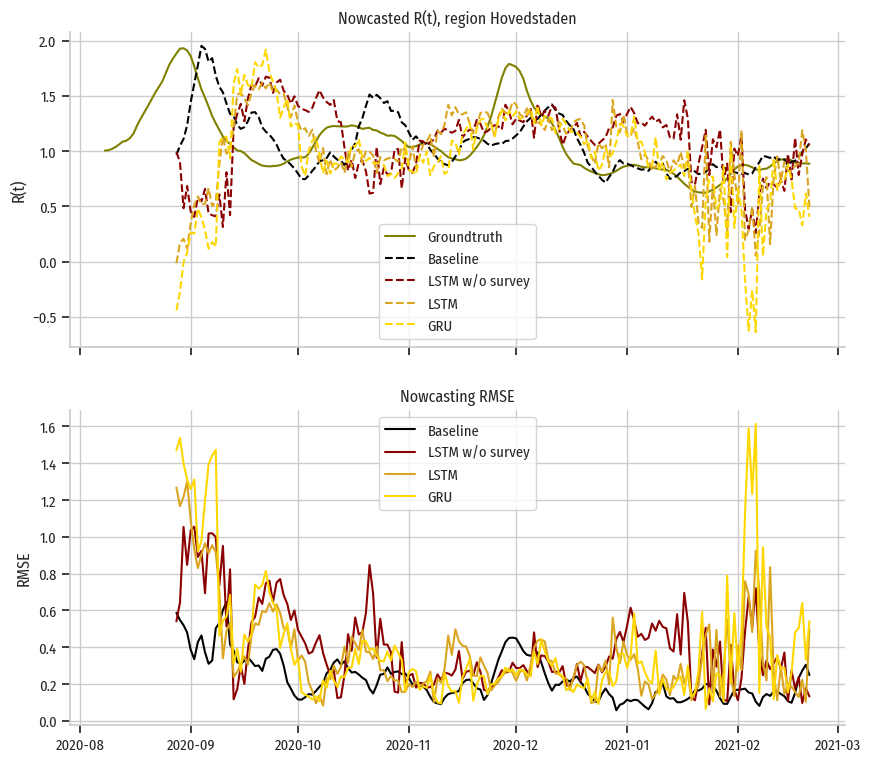

In [51]:
_, axs = plt.subplots(2, 1, figsize=(10,9), sharex=True)

sns.lineplot(x=dates['Hovedstaden'], y=np.array(y['Hovedstaden']), label='Groundtruth', color='olive', ax=axs[0])
sns.lineplot(x=dates['Hovedstaden'][DELAY+1:], y=nowc['Baseline'], label='Baseline', color='black', ls='--', ax=axs[0])
sns.lineplot(x=dates['Hovedstaden'][DELAY+1:], y=nowc['LSTM w/o survey'], label='LSTM w/o survey', color='darkred', ls='--', ax=axs[0])
sns.lineplot(x=dates['Hovedstaden'][DELAY+1:], y=nowc['LSTM'], label='LSTM', color='goldenrod', ls='--', ax=axs[0])
sns.lineplot(x=dates['Hovedstaden'][DELAY+1:], y=nowc['GRU'], label='GRU', color='gold', ls='--', ax=axs[0])
axs[0].set(title='Nowcasted R(t), region Hovedstaden', ylabel='R(t)')

sns.lineplot(x=dates['Hovedstaden'][DELAY+1:], y=res['Baseline'], label='Baseline', color='black', ax=axs[1])
sns.lineplot(x=dates['Hovedstaden'][DELAY+1:], y=res['LSTM w/o survey'], label='LSTM w/o survey', color='darkred', ax=axs[1])
sns.lineplot(x=dates['Hovedstaden'][DELAY+1:], y=res['LSTM'], label='LSTM', color='goldenrod', ax=axs[1])
sns.lineplot(x=dates['Hovedstaden'][DELAY+1:], y=res['GRU'], label='GRU', color='gold', ax=axs[1])
axs[1].set(title='Nowcasting RMSE', ylabel='RMSE')

plt.show()

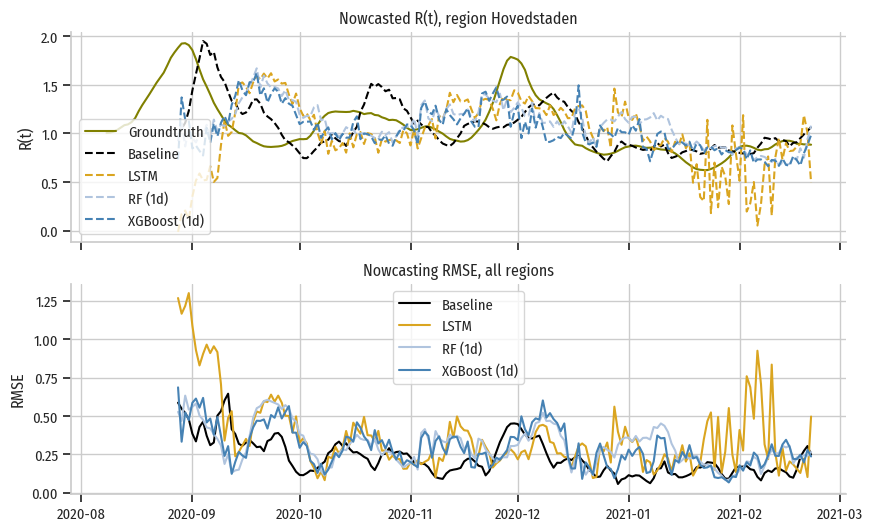

In [61]:
_, axs = plt.subplots(2, 1, figsize=(10,6), sharex=True)

sns.lineplot(x=dates['Hovedstaden'], y=np.array(y['Hovedstaden']), label='Groundtruth', color='olive', ax=axs[0])
sns.lineplot(x=dates['Hovedstaden'][DELAY+1:], y=nowc['Baseline'], label='Baseline', color='black', ls='--', ax=axs[0])
sns.lineplot(x=dates['Hovedstaden'][DELAY+1:], y=nowc['LSTM'], label='LSTM', color='goldenrod', ls='--', ax=axs[0])
sns.lineplot(x=dates['Hovedstaden'][DELAY+1:], y=nowc['RF (1d)'], label='RF (1d)', color='lightsteelblue', ls='--', ax=axs[0])
sns.lineplot(x=dates['Hovedstaden'][DELAY+1:], y=nowc['XGBoost (1d)'], label='XGBoost (1d)', color='steelblue', ls='--', ax=axs[0])
axs[0].set(title='Nowcasted R(t), region Hovedstaden', ylabel='R(t)')

sns.lineplot(x=dates['Hovedstaden'][DELAY+1:], y=res['Baseline'], label='Baseline', color='black', ax=axs[1])
sns.lineplot(x=dates['Hovedstaden'][DELAY+1:], y=res['LSTM'], label='LSTM', color='goldenrod', ax=axs[1])
sns.lineplot(x=dates['Hovedstaden'][DELAY+1:], y=res['RF (1d)'], label='RF (1d)', color='lightsteelblue', ax=axs[1])
sns.lineplot(x=dates['Hovedstaden'][DELAY+1:], y=res['XGBoost (1d)'], label='XGBoost (1d)', color='steelblue', ax=axs[1])
axs[1].set(title='Nowcasting RMSE, all regions', ylabel='RMSE')

plt.savefig('figures/causal_rt.png', bbox_inches='tight', pad_inches=0., dpi=1200)
plt.show()

In [57]:
res.mean()

Baseline             0.229411
LSTM w/o survey      0.400106
LSTM                 0.365509
GRU                  0.397891
RF (1d)              0.308251
XGBoost (1d)         0.295741
MLP (1d)           587.488962
RF (3d)              0.322840
XGBoost (3d)         0.314596
MLP (3d)           430.024491
RF (5d)              0.334328
XGBoost (5d)         0.318835
MLP (5d)           429.760061
dtype: float64